In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GASF, GADF
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.utils import to_categorical
from sklearn.model_selection import TimeSeriesSplit
import datetime

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [2]:
stockFileNames=os.listdir('./Stocks/')

In [3]:
stockSymbol=[]
col_names=['Date','Open','High','Low','Close','Volume','c']
dataList=list()
for f in stockFileNames:
    symbol=[str.upper(f.split('.')[0])]
    fileName='./Stocks/'+f
    fp=open(fileName,'r')
    if len(fp.read())>0:
        data=np.array(pd.read_csv(fileName,header=None))
        for d in data[1:]:
            dataList.append(d)
            stockSymbol.append(symbol)
        
    fp.close()
print('DONE!!')

DONE!!


In [4]:
np.shape(dataList),np.shape(stockSymbol)

((14887665, 7), (14887665, 1))

In [5]:
df1=pd.DataFrame(dataList,columns=col_names)
df2=pd.DataFrame(stockSymbol,columns=['SYMBOL'])

In [6]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)
df['Date'][:10]

0    2017-01-03
1    2017-01-04
2    2017-01-05
3    2017-01-06
4    2017-01-09
5    2017-01-10
6    2017-01-11
7    2017-01-12
8    2017-01-13
9    2017-01-17
Name: Date, dtype: object

In [7]:
allCloseDF=df[['Date','Close','SYMBOL']]
allCloseDF.head(5)

,Date,Close,SYMBOL
0,2017-01-03,24.692,OUSM
1,2017-01-04,25.026,OUSM
2,2017-01-05,24.849,OUSM
3,2017-01-06,24.781,OUSM
4,2017-01-09,24.572,OUSM


In [8]:
def getCloseDataFromSymbols(df,symbol_list):
    return df[df['SYMBOL'].isin(symbol_list)][['Date','Close']]

resultDF=getCloseDataFromSymbols(allCloseDF,['AMZN','FB','GOOGL','NFLX', 'AMZA' ])
len(resultDF)

13849

In [9]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)

,Date,Open,High,Low,Close,Volume,c,SYMBOL
0,2017-01-03,24.88,24.88,24.568,24.692,12957,0,OUSM
1,2017-01-04,24.732,25.944,24.732,25.026,10840,0,OUSM
2,2017-01-05,25.874,25.874,24.8,24.849,13104,0,OUSM
3,2017-01-06,24.82,24.858,24.771,24.781,2069,0,OUSM
4,2017-01-09,24.79,24.79,24.572,24.572,17870,0,OUSM


In [10]:
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
scaler = MinMaxScaler(feature_range=(0, 1))

def getPastSequenceData(df,window):
    #df=np.array(df)
    X=[]
    y=[]
    p = scaler.fit_transform(np.array(df['Close']).reshape(-1,1)) 
    #shuffle(p)
    for i in range(1,len(df)-window,window):
        #print(df[i-1:i+window-1],df[i+window-1])
        date=df['Date'].iloc[i]
        date=date.replace('-','')
        #print(date)
        date=np.array(date)
        vals=np.array(p[i-1:i+window-1])
        temp=vals
        X.append(temp)
        y.append(p[i+window-1])
    return X,y

In [11]:
#resultDF = scaler.fit_transform(resultDF)
print (resultDF.shape)

X,y=getPastSequenceData(resultDF,8)
X=np.array(X)

X=X.reshape(X.shape[0],X.shape[1],1)
y=np.array(y)
np.shape(X),np.shape(y)


(13849, 2)


/home/karimmady/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((1730, 8, 1), (1730, 1))

In [12]:
from sklearn.preprocessing import MinMaxScaler
tsSplit=TimeSeriesSplit(n_splits=5)


for train_index,test_index in tsSplit.split(X):
    X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = y[:len(train_index)], y[len(train_index): (len(train_index)+len(test_index))]


print (y_train)
print (X_train.shape[1:])
print(X_train.shape)

[[0.01187533]
 [0.01202732]
 [0.01200788]
 ...
 [0.22220946]
 [0.20837052]
 [0.18442192]]
(8, 1)
(1442, 8, 1)


In [23]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, AveragePooling1D, MaxPooling1D
from keras.layers import Conv1D, Conv2DTranspose, UpSampling2D, GRU
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, Concatenate, Reshape
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.2
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        Input_shape = (9,1)
        self.D.add(Conv1D(32, 3, padding='same', input_shape = Input_shape))
        self.D.add(Activation('elu'))
        self.D.add(Dropout(dropout))

        self.D.add(Conv1D(32, 3, padding='same'))
        self.D.add(Activation('elu'))
        self.D.add(Dropout(dropout))
        self.D.add(MaxPooling1D(pool_size=3))
        
        self.D.add(Conv1D(64, 3, padding='same'))
        self.D.add(Activation('elu'))
        self.D.add(Dropout(dropout))

        self.D.add(Conv1D(64, 3, padding='same'))
        self.D.add(Activation('elu'))
        self.D.add(Dropout(dropout))
        self.D.add(MaxPooling1D(pool_size=3))

        # Out: 1-dim probability
        self.D.add(Flatten(input_shape=Input_shape))
        self.D.add(Dense(512))
        self.D.add(Dropout(0.20))
        self.D.add(Dense(256))
        self.D.add(Dropout(0.20))
        self.D.add(Dense(128))
        self.D.add(Dropout(0.20))
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        Input_shape = (8,1)
        
        self.G.add(Conv1D(32, 2, padding='same', input_shape=Input_shape))
        self.G.add(Activation('elu'))
        self.G.add(Conv1D(32, 2, padding='same'))
        self.G.add(Activation('elu'))
        self.G.add(AveragePooling1D(pool_size=2))
        self.G.add(Dropout(0.2))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(GRU(30, input_shape=Input_shape))
        #self.G.add(Flatten())
        self.G.add(Dense(200))
        self.G.add(Dropout(0.20))
        self.G.add(Dense(50))
        self.G.add(Dropout(0.20))
        self.G.add(Dense(1))
        #self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM
    
    def complete_model(self):
        if self.AM:
            return self.AM
        X = keras.layers.Input(shape=(8,1))
        dm = self.discriminator()
        gm = self.generator()
        pred = gm(X)
        expanded_pred = Reshape((1,1))(pred)
        concat = Concatenate(axis=1)([X, expanded_pred])
        output = dm(concat)
        self.AM = keras.models.Model(inputs=[X], outputs=[output])
        self.AM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):

        self.x_train = X_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.generator = self.DCGAN.generator()
        self.complete = self.DCGAN.complete_model()

    def train(self, train_steps=2000, batch_size=256, save_interval=0, mode=True):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[7, 1])
        for i in range(train_steps):
            
            noise = np.random.uniform(0, 1.0, size=[self.x_train.shape[0], 8,1]) ##########
            #print noise
            #sequence_fake = self.generator.predict(self.x_train) #########
            sequence_fake = self.generator.predict(self.x_train) #########
            #print sequence_fake
            x_fake = np.concatenate([self.x_train.squeeze(), sequence_fake], axis = 1) ###
            y_fake = np.zeros((x_fake.shape[0], 1))
            x_real = np.concatenate([self.x_train.squeeze(), y_train], axis=1)
            y_real = np.ones((x_fake.shape[0], 1))
            if mode==True:
                x = np.concatenate([x_fake, x_real])
                y = np.concatenate([y_fake, y_real])
            else:
                x = np.concatenate([x_fake, x_real])
                y = np.concatenate([y_real, y_fake])
            #print x_fake
            d_loss = self.discriminator.train_on_batch(np.expand_dims(x, -1), y)
            optimizer = RMSprop(lr=0.0002, decay=6e-8)

            for layer in self.discriminator.layers:
                layer.trainable = False
            self.discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            x = self.x_train
            y = np.ones((self.x_train.shape[0], 1))
#             print (x)
            a_loss = self.complete.train_on_batch(x,y)
            
            for layer in self.discriminator.layers:
                layer.trainable=True
            self.discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            #self.discriminator.summary()
#             noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
#             a_loss = self.adversarial.train_on_batch(noise.reshape(7,1), y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)

if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    #timer = ElapsedTimer()
    mnist_dcgan.train(train_steps=10, batch_size=256, save_interval=500)
    mnist_dcgan.train(train_steps=10, batch_size=256, save_interval=500, mode = False)
    #timer.elapsed_time()
    #mnist_dcgan.plot_images(fake=True)
#mnist_dcgan.plot_images(fake=False, save2file=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 9, 32)             128       
_________________________________________________________________
activation_40 (Activation)   (None, 9, 32)             0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 9, 32)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 9, 32)             3104      
_________________________________________________________________
activation_41 (Activation)   (None, 9, 32)             0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 9, 32)             0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 3, 32)             0         
__________

In [24]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = mnist_dcgan.generator.predict(X_train)
testPredict =mnist_dcgan.generator.predict(X_test)

print (testPredict)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
#print(testPredict[400:],'\n\n\n\n',testY[400:])


[[ 6.5657277]
 [ 6.52355  ]
 [ 6.1205153]
 [ 6.167235 ]
 [ 6.1100636]
 [ 5.882875 ]
 [ 5.5965605]
 [ 5.632631 ]
 [ 5.8490343]
 [ 5.7696314]
 [ 5.891674 ]
 [ 5.7994328]
 [ 6.021728 ]
 [ 6.1256585]
 [ 6.014902 ]
 [ 5.8259044]
 [ 5.978814 ]
 [ 6.0923305]
 [ 6.214637 ]
 [ 6.300411 ]
 [ 6.382079 ]
 [ 6.361119 ]
 [ 6.463279 ]
 [ 6.6041436]
 [ 6.4662037]
 [ 6.4867864]
 [ 6.559149 ]
 [ 6.6271076]
 [ 6.7069836]
 [ 6.7005043]
 [ 6.7926545]
 [ 6.788913 ]
 [ 6.965568 ]
 [ 6.9454966]
 [ 7.1537266]
 [ 7.311548 ]
 [ 7.26346  ]
 [ 7.4414845]
 [ 7.49863  ]
 [ 7.5294714]
 [ 7.601968 ]
 [ 7.708296 ]
 [ 7.529887 ]
 [ 7.248274 ]
 [ 7.2037706]
 [ 7.237572 ]
 [ 7.2818956]
 [ 7.4135113]
 [ 7.359506 ]
 [ 7.401603 ]
 [ 7.3762717]
 [ 7.185521 ]
 [ 7.047817 ]
 [ 6.893516 ]
 [ 6.952689 ]
 [ 6.961903 ]
 [ 6.831615 ]
 [ 6.742798 ]
 [ 6.8746486]
 [ 6.9294543]
 [ 6.9735255]
 [ 6.776651 ]
 [ 6.768881 ]
 [ 6.894238 ]
 [ 7.1464562]
 [ 7.2040443]
 [ 7.586762 ]
 [ 7.6884394]
 [ 7.699392 ]
 [ 7.536943 ]
 [ 7.4536033]
 [ 7.5

Average Training Difference: 5860.96 
Average Testing Difference: 10076.86 


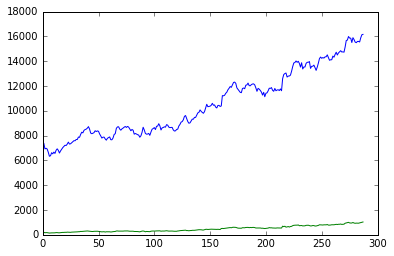

In [25]:

trainScore=0
testScore=0
# calculate root mean squared error
for i in range (trainY.shape[0]):
    trainScore += math.sqrt(mean_squared_error(trainY[i], trainPredict[i]))
trainScore=trainScore/trainY.shape[0]

for i in range (testY.shape[0]):
    testScore += math.sqrt(mean_squared_error(testY[i],testPredict[i]))
testScore=testScore/testY.shape[0]

print('Average Training Difference: %.2f ' % (trainScore))
print('Average Testing Difference: %.2f ' % (testScore))
# for i in range(testPredict.shape[0]):
#     if testPredict[i] > 1000:
#         print testPredict[i]
plt.plot(testPredict)

plt.plot(testY)
plt.show()
